In [49]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# preparing data
from sklearn.decomposition import PCA

from models import *
from methods import *
import pandas as pd
import numpy as np
import torch
import math
import os
from os import path
import torch.nn as nn

model_name = "DSVDD"
DATASET = 'full_data'

"""___________________Hyper Parameters________________________"""
CROSS_VALIDATION_SHUFFLE = True
TRIM_DATA = False
FILTER_CORRCOEF = False
REMOVE_NOISE = True
REMOVE_NOISE_THRESHOLD = 5
DENOISE = False
NOISE_FACTOR = 0.05
NOISE_FRACTION = 0.8
NORMALIZE_DATA = True
NORMALIZATION_SCHEME = 'standard_scaling'
LATENT_DIM = 4
HIDDEN_DIM = 64
WEIGHT_DECAY = 1e-7
LEARNING_RATE = 1e-4
EPOCHS = 6000
ACTIVATION = 'leaky_relu'
BATCH_SIZE = 1024
INITIALIZATION = 'xavier_normal'
ALGO = 'SGD'
v = 1e-0
SIGMA = 1e-6
OUTPUT_FEATURE = 8
GAMMA = 0
ATTENTION = False
"""___________________________________________________________"""
#device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if DATASET == 'network_data':
    raw_data = np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'medical_data':
    raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_data = np.concatenate((np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    idc = np.bool_(np.loadtxt('../data/idc/data_idc1.csv', delimiter=','))
    anomalous_data = anomalous_data[idc,:]
    idc = np.bool_(np.loadtxt('../data/idc/data_idc2.csv', delimiter=','))
    anomalous_data = anomalous_data[idc,:]

train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_data, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA, normalization_scheme=NORMALIZATION_SCHEME,
            filterLinearDependencies=FILTER_CORRCOEF, filter_threshold=0.98, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD)

train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
NUM_FEATURE = len(train_data[0])
print(train_data.shape, anomalous_data.shape)
print(torch.max(anomalous_data))

Train data shape after trim:  (8005, 20)
Train data shape after filter corrcoef:  (8005, 20)
Normalization scheme:  standard_scaling
removeNoise = True ---- remaining Data Shape = (7830, 20); noise proportion: 0.021861336664584674
Train data shape after normalize:  (7830, 20)
torch.Size([7830, 20]) torch.Size([895, 20])
tensor(6.4891)


In [32]:
# use VAE to generate from noise to train
criterion = nn.MSELoss(reduction='sum')
attNet = None
if ATTENTION:
    attNet = AttentionNet(num_feature=NUM_FEATURE, sample_size=len(train_data), E_dim=12)
    NUM_FEATURE = attNet.E_Dim
model_VAE = VAE(NUM_FEATURE, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, activation=ACTIVATION, initialization=INITIALIZATION, sigma=SIGMA)
# train
print("Attention: ", ATTENTION)
loss_array = train(model_VAE, 'SGD', EPOCHS, train_data, train_data, criterion, batch_size=BATCH_SIZE, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        ,grad_limit=1e2, att=attNet)
torch.save(model_VAE.state_dict(), '../model/param_VAE')

Attention:  False
epoch : 1/6000, loss = 9.982551
epoch : 2/6000, loss = 9.835214
epoch : 3/6000, loss = 9.722266
epoch : 4/6000, loss = 9.619391
epoch : 5/6000, loss = 9.493181
epoch : 6/6000, loss = 9.312595
epoch : 7/6000, loss = 9.108974
epoch : 8/6000, loss = 8.824678
epoch : 9/6000, loss = 8.489918
epoch : 10/6000, loss = 8.147179
epoch : 11/6000, loss = 7.790497
epoch : 12/6000, loss = 7.483741
epoch : 13/6000, loss = 7.179537
epoch : 14/6000, loss = 6.958964
epoch : 15/6000, loss = 6.765691
epoch : 16/6000, loss = 6.604614
epoch : 17/6000, loss = 6.505069
epoch : 18/6000, loss = 6.371881
epoch : 19/6000, loss = 6.265787
epoch : 20/6000, loss = 6.186941
epoch : 21/6000, loss = 6.060091
epoch : 22/6000, loss = 5.971571
epoch : 23/6000, loss = 5.862712
epoch : 24/6000, loss = 5.725386
epoch : 25/6000, loss = 5.615155
epoch : 26/6000, loss = 5.490883
epoch : 27/6000, loss = 5.340300
epoch : 28/6000, loss = 5.234903
epoch : 29/6000, loss = 5.093984
epoch : 30/6000, loss = 4.959435
e

In [50]:
# check latent distribution
model_VAE.eval()
train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)

code = model_VAE.encoding_layer(train_data)
code_attack = model_VAE.encoding_layer(anomalous_data)
mu, var = model_VAE.generate_mean(code), torch.exp(model_VAE.generate_log_var(code))
mu_attack, var_attack = model_VAE.generate_mean(code_attack), torch.exp(model_VAE.generate_log_var(code_attack))
print(f'Z mean train: {torch.mean(mu, dim=0)}, \nZ sd train: {torch.mean(var, dim=0)}')
print(f'Z mean attack: {torch.mean(mu_attack, dim=0)}, \nZ sd attack: {torch.mean(var_attack, dim=0)}')

excluded_range_lower = torch.mean(mu, dim=0) - 3 * torch.mean(var, dim=0)
excluded_range_upper = torch.mean(mu, dim=0) + 3 * torch.mean(var, dim=0)
print(excluded_range_lower, excluded_range_upper)
# generate synthetic data
generation_size = len(train_data)*5
random_choices = [-1, 1]

#anomalous_code = model_VAE.encode(torch.tensor(anomalous_data).to(torch.float).to(device))
#mu, scale = torch.mean(anomalous_code, dim=0), torch.std(anomalous_code, dim=0, unbiased=True)
#z_p = torch.normal(mu.expand(generation_size, LATENT_DIM), scale.expand(generation_size, LATENT_DIM))
mu, scale = 10, 10
z_p = torch.normal(torch.ones(generation_size, LATENT_DIM)*mu*torch.tensor(np.random.choice(random_choices, size=(generation_size, LATENT_DIM), replace=True)), scale*torch.ones(generation_size, LATENT_DIM))

z_p = torch.empty(generation_size, LATENT_DIM).uniform_(-40, 40)
idc = torch.sum(torch.logical_or(excluded_range_lower > z_p, z_p > excluded_range_upper), dim=1) == LATENT_DIM
z_p = z_p[idc]
generation_size = z_p.shape[0]
print(z_p.shape)

z_p = z_p.to(torch.float).to(device)
generated_data = model_VAE.decode(z_p)

Z mean train: tensor([ 3.8769, -7.6098, -3.4909,  0.0407], grad_fn=<MeanBackward1>), 
Z sd train: tensor([0.0029, 0.0031, 0.0057, 0.0032], grad_fn=<MeanBackward1>)
Z mean attack: tensor([ 3.5195, -7.5969, -2.9736,  0.6465], grad_fn=<MeanBackward1>), 
Z sd attack: tensor([0.0011, 0.0020, 0.0053, 0.0011], grad_fn=<MeanBackward1>)
tensor([ 3.8684, -7.6193, -3.5081,  0.0312], grad_fn=<SubBackward0>) tensor([ 3.8855, -7.6004, -3.4736,  0.0502], grad_fn=<AddBackward0>)
torch.Size([39110, 4])


/Users/xxd/Documents/Course/MIE696/mie696/src/methods.py:486: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res.append(torch.tensor(arr).to(torch.float).to(device))


In [51]:
criterion = lambda *args: 0
R = torch.tensor(1, dtype=float, requires_grad=True)
model = DSVDD(NUM_FEATURE, output_feature=OUTPUT_FEATURE, center=torch.tensor([[0]]), v=v, R=R, gamma=1e-0, hidden_dim=HIDDEN_DIM, activation=ACTIVATION, initialization=INITIALIZATION,)

In [52]:
# train
if NORMALIZE_DATA:
        loss_array = train(model, ALGO, EPOCHS, train_data, train_data, criterion, batch_size=BATCH_SIZE, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
                ,grad_limit=1e2, dsvdd_y=generated_data)
else:
        loss_array = train(model, ALGO, EPOCHS, train_data, train_data, criterion, batch_size=BATCH_SIZE, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        ,grad_limit=1e2,)
torch.save(model.state_dict(), '../model/param_AE')

epoch : 1/6000, loss = 0.347209
epoch : 2/6000, loss = 0.345845
epoch : 3/6000, loss = 0.344501
epoch : 4/6000, loss = 0.343174
epoch : 5/6000, loss = 0.341865
epoch : 6/6000, loss = 0.340573
epoch : 7/6000, loss = 0.339298
epoch : 8/6000, loss = 0.338039
epoch : 9/6000, loss = 0.336796
epoch : 10/6000, loss = 0.335569
epoch : 11/6000, loss = 0.334356
epoch : 12/6000, loss = 0.333159
epoch : 13/6000, loss = 0.331975
epoch : 14/6000, loss = 0.330806
epoch : 15/6000, loss = 0.329651
epoch : 16/6000, loss = 0.328509
epoch : 17/6000, loss = 0.327380
epoch : 18/6000, loss = 0.326264
epoch : 19/6000, loss = 0.325161
epoch : 20/6000, loss = 0.324070
epoch : 21/6000, loss = 0.322991
epoch : 22/6000, loss = 0.321923
epoch : 23/6000, loss = 0.320868
epoch : 24/6000, loss = 0.319824
epoch : 25/6000, loss = 0.318791
epoch : 26/6000, loss = 0.317769
epoch : 27/6000, loss = 0.316757
epoch : 28/6000, loss = 0.315757
epoch : 29/6000, loss = 0.314766
epoch : 30/6000, loss = 0.313785
epoch : 31/6000, lo

torch.Size([895, 20])
Train average loss:0.0
Train code square: tensor([[2.0829],
        [1.0374],
        [0.9781],
        ...,
        [0.7692],
        [0.7059],
        [0.3351]], grad_fn=<SumBackward1>)
Train error: 2598.2046204145013, Train R square: 1.0749190231241188
Validation average loss:0.0
Test average loss:  0.0
Anomalous average loss:  0.0

Train code outside hypersphere percentage: 0.27254152297973633
Test code outside hypersphere percentage: 0.2986137270927429
Anomalous code outside hypersphere percentage: 0.2692737579345703



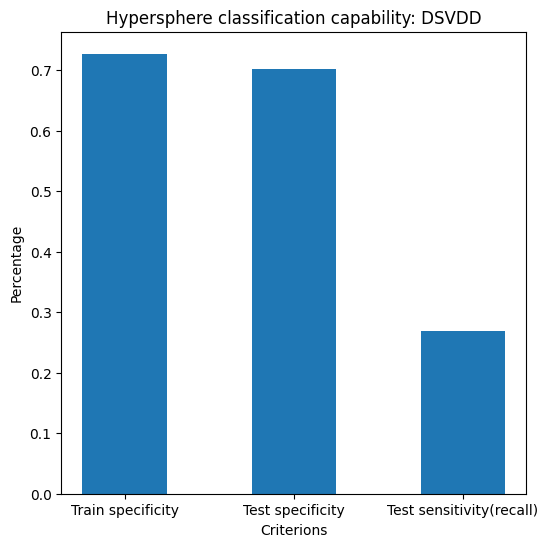

In [53]:
# evaluation
print(anomalous_data.shape)
model.eval()

train_code = model(train_data)
train_code_square = torch.sum((train_code - model.center) ** 2, dim=1, keepdim=True)
print(f"Train average loss:{criterion(model(train_data), train_data) / len(train_data)}")
print(f"Train code square: {train_code_square}")
print(f"Train error: {model.error}, Train R square: {model.R.item() ** 2}")

print(f"Validation average loss:{criterion(model(validation_data), validation_data) / len(validation_data)}")
print("Test average loss: ", criterion(model(test_data), test_data)/len(test_data))
print("Anomalous average loss: ", criterion(model(anomalous_data), anomalous_data)/len(anomalous_data))
train_specificity, test_specificity, test_sensitivity = model.insidePercentage(train_data), model.insidePercentage(test_data), 1-model.insidePercentage(anomalous_data)
print(f"\nTrain code outside hypersphere percentage: {1-train_specificity}")
print(f"Test code outside hypersphere percentage: {1-model.insidePercentage(test_data)}")
print(f"Anomalous code outside hypersphere percentage: {test_sensitivity}\n")
d = {"Train specificity":train_specificity, 
    "Test specificity":test_specificity, 
    "Test sensitivity(recall)":test_sensitivity}
plot_bar(d, model_name, False, save_path='../graphs/DSVDD/sensitivity_specificity')

In [6]:
# use TSNE to show code distribution
PERPLEXITY = 10
if True:
    model.eval()
    full_code = model(torch.cat((test_data, anomalous_data), dim=0)).detach().numpy()
    full_label = [0 for _ in range(len(test_data))] + [1 for _ in range(len(anomalous_data))]
    from sklearn.manifold import TSNE

    # We want to get TSNE embedding with 2 dimensions
    n_components = 2
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    #print(full_data.shape)
    tsne_code = tsne.fit_transform(full_code)
# use TSNE to show LCS 
if False:
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    full_lcs = np.concatenate((lcs_array_test, lcs_array_attack), axis=0)
    #print(full_data.shape)
    tsne_lcs = tsne.fit_transform(full_lcs)

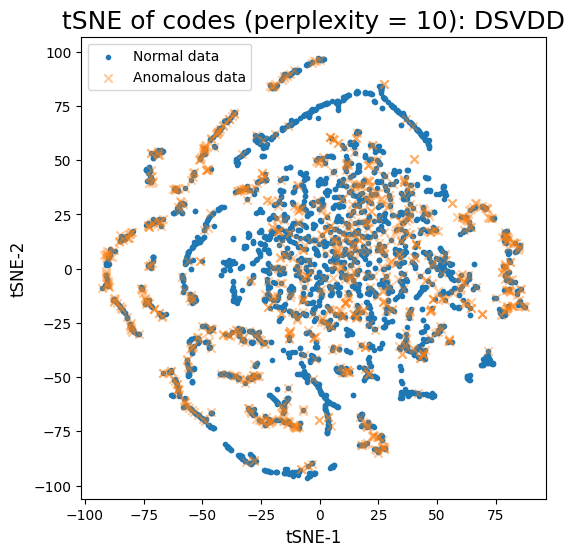

In [7]:
import matplotlib.pyplot as plt
plot1_upper_lim = 1e12
plot1_lower_lim = 0e-1
if True:
    # Plot the result of our TSNE with the label color coded
    fig3 = plt.figure(figsize = (6,6))
    ax3 = fig3.add_subplot(1,1,1
    #, projection='2d'
    )
    l1, l2 = len(test_data), len(anomalous_data)
    ax3.scatter(tsne_code[:l1,0], tsne_code[:l1,1], marker=".").set_label('Normal data')
    ax3.scatter(tsne_code[l1:,0], tsne_code[l1:,1], marker="x", alpha=0.4).set_label('Anomalous data')
    ax3.set_title(('tSNE of codes (perplexity = ' + str(PERPLEXITY) + '): ' + model_name), fontsize = 18)
    ax3.set_xlabel('tSNE-1', fontsize = 12)
    ax3.set_ylabel('tSNE-2', fontsize = 12)
    ax3.legend()

<Figure size 500x500 with 0 Axes>

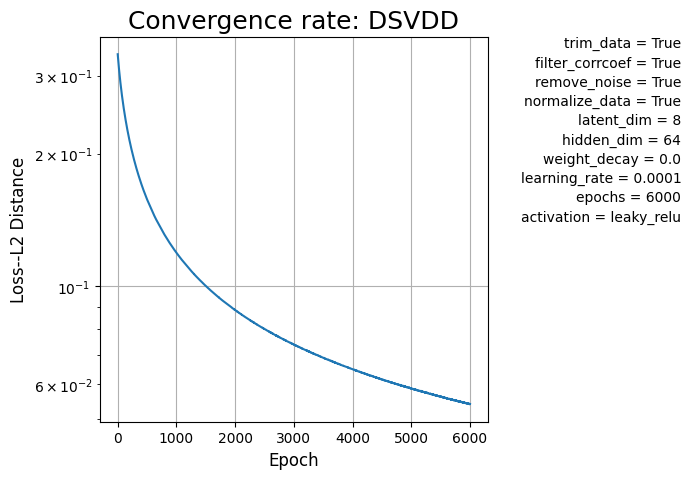

In [8]:
# convergence
def visualize_convergence(loss_array,  model_name:str, save:bool=False, **kwargs):
    fig = plt.figure(figsize = (5, 5))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Epoch', fontsize = 12)
    ax.set_ylabel('Loss--L2 Distance', fontsize = 12)
    ax.set_yscale('log')
    ax.set_title('Convergence rate: ' + model_name, fontsize = 18)
    ax.grid()
    ax.plot(loss_array)
    # annotate graph
    x, y, i = 1.5, 1, 1
    for key, value in kwargs.items():
        ax.text(x, y, str(key) + " = " + str(value), ha='right', va='top', transform = ax.transAxes)
        y -= 0.05
    # save graph
    if save:
        path = "../graphs/Convergence"
        filename = model_name
        pathfile = os.path.normpath(os.path.join(path, filename))
        if not os.path.exists(path):
            os.makedirs(path)
        while os.path.isfile(pathfile + '.png'):
            pathfile = os.path.normpath(os.path.join(path, filename + str(i)))
            i += 1
        fig.savefig(pathfile)
    return ax

fig = plt.figure(figsize = (5, 5))
parameters = {"trim_data": TRIM_DATA, "filter_corrcoef": FILTER_CORRCOEF, "remove_noise": REMOVE_NOISE,
"normalize_data": NORMALIZE_DATA,
"latent_dim": LATENT_DIM,
"hidden_dim": HIDDEN_DIM,
"weight_decay": WEIGHT_DECAY,
"learning_rate": LEARNING_RATE,
"epochs": EPOCHS,   
"activation": ACTIVATION}
ax = visualize_convergence(loss_array, model_name, save=True, **parameters)

NameError: name 'y_ground_truth' is not defined

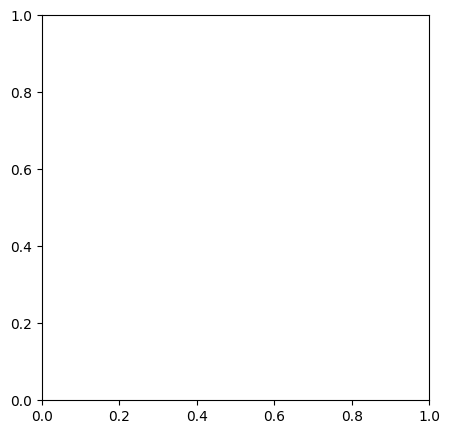

In [9]:
# ROC & AUC
from sklearn import metrics

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 

fpr_MSE, tpr_MSE, _ = metrics.roc_curve(y_ground_truth,  y_scores)
auc_MSE = metrics.roc_auc_score(y_ground_truth,  y_scores)
fpr_LCS, tpr_LCS, _ = metrics.roc_curve(y_ground_truth,  y_scores_lcs)
auc_LCS = metrics.roc_auc_score(y_ground_truth,  y_scores_lcs)

y_scores_kl = kl_div_test + kl_div_attack
fpr_KL, tpr_KL, _ = metrics.roc_curve(y_ground_truth,  y_scores_kl)
auc_KL = metrics.roc_auc_score(y_ground_truth,  y_scores_kl)


ax.set_title(model_name + '(normalized data)\n ROC Curve and AUC', fontsize = 18)
ax.plot(fpr_MSE,tpr_MSE, label="MSE auc="+str(auc_MSE))
ax.plot(fpr_LCS,tpr_LCS, label="LCS auc="+str(auc_LCS))
ax.plot(fpr_KL,tpr_KL, label="KL auc="+str(auc_LCS))
ax.set_xlabel("False Positive Rate", fontsize=15)
ax.set_ylabel("True Positive Rate", fontsize=15)
ax.legend(loc=4)

In [ ]:
# classify data
if DATASET == 'network_data':
    model.load_state_dict(torch.load('../model/param_DOCAE_8_8'))
    model.eval()
    anomalous_data = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_data, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA,
                filterLinearDependencies=True, filter_threshold=0.97, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD)
    anomalous_data = torch.tensor(anomalous_data).to(torch.float).to(device)
    idc_to_save = (torch.sum(model.encode(anomalous_data)**2, dim=1) <= model.R**2)
    print(idc_to_save.shape)
    #df = pd.DataFrame(np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[idc_to_save,]) #convert to a dataframe
    #df.to_csv('../data/network_flow_attack_data_undetected.csv', index=False) #save to file

    #df = pd.DataFrame(anomalous_data[idc_to_save,]) #convert to a dataframe
    #df.to_csv('../data/network_flow_attack_data_temp_undetected.csv', index=False) #save to file

    medical_data = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')
    df = pd.DataFrame(medical_data[idc_to_save,]) #convert to a dataframe
    df.to_csv('../data/medical_attack_data_undetected.csv', index=False) #save to file
